In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.models import resnet50
from tqdm.notebook import tqdm

sns.set_theme()

In [119]:
from nircoloring.dataset.downloader import SerengetiMetaDataSource
from nircoloring.evaluation.config import *

In [4]:
meta_data_source = SerengetiMetaDataSource()


def load_labels():
    annotations = meta_data_source.load_annotations()
    return annotations.groupby("image_id")["category_id"].unique()


def load_images():
    images = meta_data_source.load_images()
    images["base_file_name"] = images["file_name"].apply(lambda filename: PosixPath(filename).stem).str.lower()
    return images[["id", "base_file_name"]].set_index("base_file_name")


images = load_images()
labels = load_labels()

In [5]:
categories = meta_data_source.load_categories()

In [6]:
def load_label_map(entries):
    matched_images = images[images.index.isin(set(entries))]
    return matched_images.reset_index().merge(labels, left_on="id", right_on="image_id", how="left").set_index(
        "base_file_name")["category_id"]

In [7]:
filenames = serengeti_night_large_nir_train.image_filenames + serengeti_night_large_nir_test.image_filenames + serengeti_night_large_nir_val.image_filenames

filenames = pd.Series(filenames).apply(lambda filename: filename.stem).str.lower()
categories_of_dataset = load_label_map(filenames)

In [83]:
category_occurrences = {}

for category_set in categories_of_dataset:
    for category in category_set:
        if category not in category_occurrences.keys():
            category_occurrences[category] = 0
        category_occurrences[category] += 1


In [95]:
TOP_INDICES = {i[0] for i in sorted(list(category_occurrences.items()), key=lambda x: x[1], reverse=True)[:7]}

{3, 4, 5, 7, 8, 15, 18}

In [96]:
transformation_map = {
    index: i
    for i, index in enumerate(TOP_INDICES)
}


def transform_indices(indices):
    new_indices = []

    for index in indices:
        if index in transformation_map.keys():
            new_indices.append(transformation_map[index])

    return np.array(new_indices)


In [97]:
from torch.utils.data.dataset import T_co
from torch.utils.data import Dataset


def combine_and_filter(filenames, images):
    data = {"filename": filenames, "image": images}
    df = pd.DataFrame(data)
    df = df.merge(load_label_map(filenames), how="left", left_on="filename", right_index=True)
    df["category_id"] = df["category_id"].apply(transform_indices)
    df = df[df["category_id"].apply(lambda categories: len(categories) > 0)]
    df = df.reset_index()
    return df


class SerengetiDataset(Dataset):
    def __init__(self, result: Result, transform, file_name_corrector=None) -> None:
        self.transform = transform

        filenames = pd.Series(result.image_filenames).apply(lambda filename: filename.stem).str.lower()
        if file_name_corrector is not None:
            filenames = filenames.apply(file_name_corrector)

        images = result.load_images()

        self.df = combine_and_filter(filenames, images)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> T_co:
        row = self.df.iloc[index]

        img = row["image"]
        img = self.transform(img.copy())

        labels_indices = row["category_id"]
        label = torch.zeros((len(TOP_INDICES),))
        label[labels_indices] = 1

        return {
            'image': img,
            'labels': label
        }

In [98]:
train_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.RandomCrop(128, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

validation_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_rgb = SerengetiDataset(
    transform=train_transformations,
    result=serengeti_night_large_rgb_train
)
train_dataset_nir = SerengetiDataset(
    transform=train_transformations,
    result=serengeti_night_large_nir_train
)

val_dataset_rgb = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_rgb_val
)
val_dataset_nir = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_nir_val
)

In [99]:
train_dataset_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=cycle_gan_serengeti_night_large_train,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)
val_dataset_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=cycle_gan_serengeti_night_large_val,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)

In [120]:
train_dataset_iis_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=iis_cycle_gan_serengeti_night_large_train,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)
val_dataset_iis_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=iis_cycle_gan_serengeti_night_large_val,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)

In [101]:
train_dataset_ihfs = SerengetiDataset(
    transform=train_transformations,
    result=ihfs_serengeti_night_large_train,
)
val_dataset_ihfs = SerengetiDataset(
    transform=train_transformations,
    result=ihfs_serengeti_night_large_val,
)

In [106]:
train_dataset_iis = SerengetiDataset(
    transform=train_transformations,
    result=iis_serengeti_night_large_train,
)
val_dataset_iis = SerengetiDataset(
    transform=train_transformations,
    result=iis_serengeti_night_large_val,
)

In [111]:
train_dataset = ConcatDataset([train_dataset_nir, train_dataset_rgb])
val_dataset = ConcatDataset([val_dataset_nir, val_dataset_rgb])

In [19]:
def train_one_epoch(model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer,
                    criterion: torch.nn.Module,
                    device):
    model.train()
    counter = 0
    train_running_loss = 0.0
    acc_running = 0.0
    for i, data in enumerate(dataloader):
        counter += 1
        data, target, = data['image'].to(device), data['labels'].to(device)
        optimizer.zero_grad()

        outputs = model(data)
        outputs = torch.sigmoid(outputs)

        loss = criterion(outputs, target)

        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

        acc_running += accuracy(outputs, target)

    train_loss = train_running_loss / counter
    acc = acc_running / counter
    return train_loss, acc

In [20]:
def validate(model: torch.nn.Module, dataloader: DataLoader, criterion: torch.nn.Module, device):
    model.eval()
    counter = 0
    val_running_loss = 0.0
    acc_running = 0.0

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            data, target = data['image'].to(device), data['labels'].to(device)

            outputs = model(data)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)

            acc_running += accuracy(outputs, target)
            val_running_loss += loss.item()

        val_loss = val_running_loss / counter
        acc = acc_running / counter

        return val_loss, acc

In [21]:
def plot(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(train_loss, label='train loss')
    axs[0].plot(val_loss, label='validation loss')
    axs[1].plot(train_acc, label='train accuracy')
    axs[1].plot(val_acc, label='validation accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()


def fit(model, epochs, optimizer, criterion, train_loader, val_loader, plot_freq=20):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    best_val_loss = 1e10
    best_model = model.state_dict()

    for epoch in tqdm(range(epochs), "Processing epochs"):
        train_epoch_loss, train_acc_epoch = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_epoch_loss, val_acc_epoch = validate(model, val_loader, criterion, device)

        train_loss.append(train_epoch_loss)
        train_acc.append(train_acc_epoch)

        val_loss.append(val_epoch_loss)
        val_acc.append(val_acc_epoch)

        print(f"Train Loss: {train_epoch_loss:.4f}, Acc: {train_acc_epoch}\n")
        print(f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_acc_epoch}\n")

        if val_epoch_loss <= best_val_loss:
            best_val_loss = val_epoch_loss
            best_model = copy.deepcopy(model.state_dict())

        if epoch % plot_freq == 0 and epoch != 0:
            plot(train_loss, val_loss, train_acc, val_acc)

    plot(train_loss, val_loss, train_acc, val_acc)
    model.load_state_dict(best_model)
    return model, best_val_loss

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [23]:
def accuracy(outputs, target: torch.Tensor):
    preds = torch.round(outputs)
    return torch.sum(torch.isclose(target, preds)).item() / (preds.size(0) * preds.size(1))

In [24]:
def train_resnet(train_dataset, val_dataset, lr):
    torch.random.manual_seed(0)
    net = resnet50()

    net.fc = nn.Sequential(
        nn.Linear(in_features=net.fc.in_features, out_features=len(TOP_INDICES)),
    )
    net.to(device)

    epochs = 100
    batch_size = 128
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return fit(net, epochs, optimizer, criterion, train_loader, val_loader)

In [25]:
def optimize_lr(training_function, lrs=None):
    if lrs is None:
        lrs = [1e-6, 1e-5, 1e-4]

    best_val_loss = 1e10
    best_network = None
    for lr in lrs:
        network, val_loss = training_function(lr)
        if val_loss <= best_val_loss:
            print(f"LR {lr} is better with loss {val_loss}")
            best_val_loss = val_loss
            best_network = network
    return best_network, best_val_loss

In [149]:
def train_resnet_freezed(train_dataset, val_dataset, lr):
    torch.random.manual_seed(0)
    net = resnet50()

    net.fc = nn.Sequential(
        nn.Linear(in_features=net.fc.in_features, out_features=len(TOP_INDICES)),
    )
    net.to(device)

    epochs = 100
    batch_size = 128
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
    criterion = nn.BCELoss()

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return fit(net, epochs, optimizer, criterion, train_loader, val_loader)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.4461, Acc: 0.7975592580782312

Val Loss: 0.3775, Acc: 0.8567708333333334
Train Loss: 0.3623, Acc: 0.8626434948979592

Val Loss: 0.3652, Acc: 0.8567708333333334
Train Loss: 0.3498, Acc: 0.8646896258503401

Val Loss: 0.3500, Acc: 0.8642743644067797
Train Loss: 0.3433, Acc: 0.8645235437925171

Val Loss: 0.3569, Acc: 0.8642743644067797
Train Loss: 0.3335, Acc: 0.8665829613095238

Val Loss: 0.3512, Acc: 0.8590975585149314
Train Loss: 0.3189, Acc: 0.8736314838435373

Val Loss: 0.3508, Acc: 0.8537315879741728
Train Loss: 0.3108, Acc: 0.8795373618197279

Val Loss: 0.3675, Acc: 0.8586940072639225
Train Loss: 0.3118, Acc: 0.8770328443877552

Val Loss: 0.3548, Acc: 0.8469342715899919
Train Loss: 0.3119, Acc: 0.8764150191326531

Val Loss: 0.3702, Acc: 0.8533217312348668
Train Loss: 0.3048, Acc: 0.883636267006803

Val Loss: 0.3679, Acc: 0.8509130347054076
Train Loss: 0.2911, Acc: 0.8907445790816327

Val Loss: 0.3443, Acc: 0.8701384685230025
Train Loss: 0.2809, Acc: 0.8925050488945577


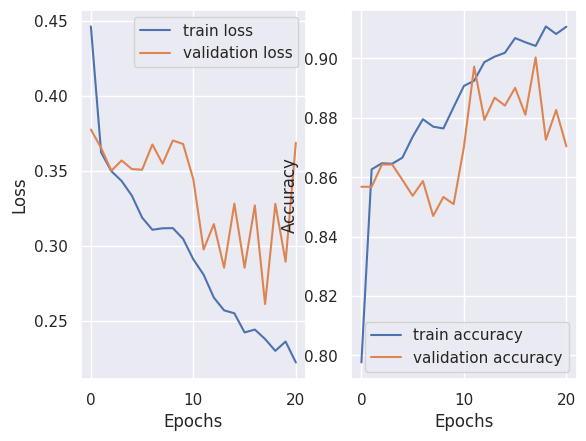

Train Loss: 0.2344, Acc: 0.9063895089285715

Val Loss: 0.2537, Acc: 0.8990428268765133
Train Loss: 0.2171, Acc: 0.9146471088435373

Val Loss: 0.2657, Acc: 0.9006255044390638
Train Loss: 0.1998, Acc: 0.9194502019557825

Val Loss: 0.2302, Acc: 0.9162568099273608
Train Loss: 0.2005, Acc: 0.9202341092687076

Val Loss: 0.3155, Acc: 0.8945848466505245
Train Loss: 0.1893, Acc: 0.9241204294217688

Val Loss: 0.2427, Acc: 0.9101467917675544
Train Loss: 0.1972, Acc: 0.9245256696428572

Val Loss: 0.3312, Acc: 0.8876614205004035
Train Loss: 0.1783, Acc: 0.9299731611394558

Val Loss: 0.2244, Acc: 0.91963655165456
Train Loss: 0.1838, Acc: 0.9267113095238093

Val Loss: 0.3027, Acc: 0.8893702078288942
Train Loss: 0.1728, Acc: 0.9313350340136052

Val Loss: 0.2491, Acc: 0.9085010593220338
Train Loss: 0.1655, Acc: 0.9352612138605445

Val Loss: 0.2463, Acc: 0.9041628833736884
Train Loss: 0.1676, Acc: 0.9323514562074829

Val Loss: 0.2096, Acc: 0.9206328188054883
Train Loss: 0.1789, Acc: 0.9294084821428571



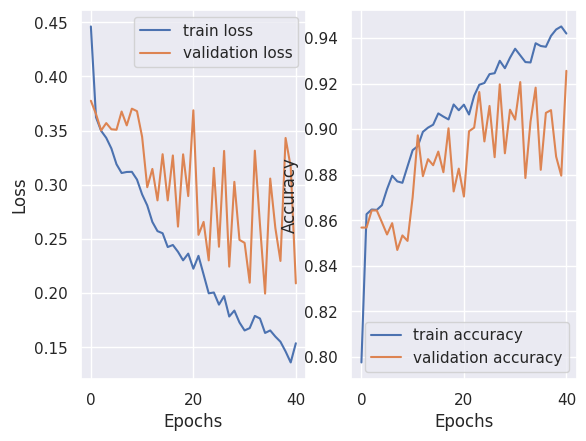

Train Loss: 0.1305, Acc: 0.9493316857993195

Val Loss: 0.3399, Acc: 0.8939542978208234
Train Loss: 0.1200, Acc: 0.9529323448129254

Val Loss: 0.2099, Acc: 0.9292839487489911
Train Loss: 0.1316, Acc: 0.9492054634353743

Val Loss: 0.3183, Acc: 0.8828566384180792
Train Loss: 0.1147, Acc: 0.9560945471938775

Val Loss: 0.2764, Acc: 0.9031098668280871
Train Loss: 0.1191, Acc: 0.9530452806122449

Val Loss: 0.2801, Acc: 0.9128140133171913
Train Loss: 0.1329, Acc: 0.9507799213435372

Val Loss: 0.2595, Acc: 0.9177764326069412
Train Loss: 0.1199, Acc: 0.9555032950680271

Val Loss: 0.2032, Acc: 0.9327582728006457
Train Loss: 0.1082, Acc: 0.9572571215986393

Val Loss: 0.2059, Acc: 0.9273292473769169
Train Loss: 0.1179, Acc: 0.9537561118197279

Val Loss: 0.3084, Acc: 0.9015965496368038
Train Loss: 0.1148, Acc: 0.9579480229591836

Val Loss: 0.1908, Acc: 0.9366992029862793
Train Loss: 0.1077, Acc: 0.9604259672619048

Val Loss: 0.3400, Acc: 0.8949253430185634
Train Loss: 0.1241, Acc: 0.9528061224489796

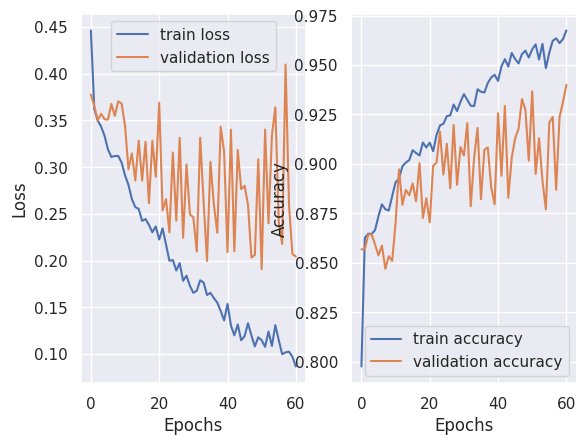

Train Loss: 0.1043, Acc: 0.9634353741496597

Val Loss: 0.2065, Acc: 0.9326952179176756
Train Loss: 0.1071, Acc: 0.958187181122449

Val Loss: 0.3135, Acc: 0.9072336561743342
Train Loss: 0.0968, Acc: 0.9647241709183675

Val Loss: 0.1977, Acc: 0.9299964689265536
Train Loss: 0.0843, Acc: 0.9683514030612246

Val Loss: 0.2943, Acc: 0.9094405770782888
Train Loss: 0.0937, Acc: 0.9673681972789115

Val Loss: 0.1968, Acc: 0.9340319814366423
Train Loss: 0.1000, Acc: 0.9616881909013606

Val Loss: 0.2056, Acc: 0.9282309322033898
Train Loss: 0.1032, Acc: 0.9615752551020408

Val Loss: 0.6964, Acc: 0.8109236279257467
Train Loss: 0.1059, Acc: 0.9578417304421767

Val Loss: 0.1961, Acc: 0.9382818805488298
Train Loss: 0.0889, Acc: 0.9666640093537415

Val Loss: 0.2736, Acc: 0.9074228208232445
Train Loss: 0.0871, Acc: 0.9661989795918365

Val Loss: 0.4926, Acc: 0.8424069309927361
Train Loss: 0.0732, Acc: 0.9719321322278911

Val Loss: 0.3105, Acc: 0.9005309221146085
Train Loss: 0.0966, Acc: 0.9647573873299319


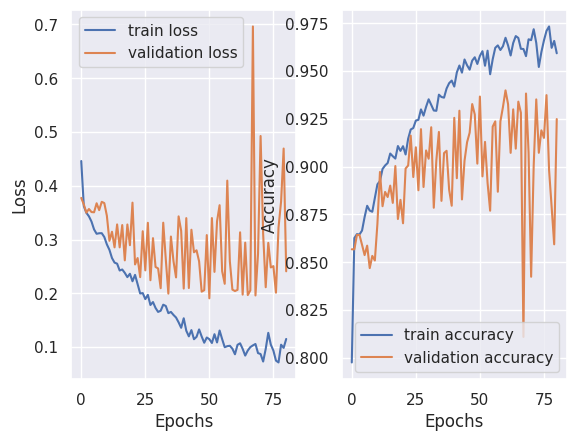

Train Loss: 0.0765, Acc: 0.9710618622448978

Val Loss: 0.2102, Acc: 0.9360749596448749
Train Loss: 0.0673, Acc: 0.9739849064625847

Val Loss: 0.2574, Acc: 0.9207589285714285
Train Loss: 0.0765, Acc: 0.970184948979592

Val Loss: 0.2393, Acc: 0.9245422215496367
Train Loss: 0.0785, Acc: 0.9719321322278912

Val Loss: 0.3126, Acc: 0.8853977502017756
Train Loss: 0.0713, Acc: 0.9721845769557825

Val Loss: 0.3236, Acc: 0.9094090496368038
Train Loss: 0.0876, Acc: 0.9692482461734694

Val Loss: 0.2217, Acc: 0.9321403349475382
Train Loss: 0.0985, Acc: 0.9637675382653063

Val Loss: 0.1929, Acc: 0.9417562046004843
Train Loss: 0.0828, Acc: 0.9689559417517007

Val Loss: 0.2869, Acc: 0.9046925443906376
Train Loss: 0.0820, Acc: 0.9700985863095238

Val Loss: 0.2353, Acc: 0.9291326170298628
Train Loss: 0.1025, Acc: 0.9636479591836734

Val Loss: 0.6833, Acc: 0.8178722760290557
Train Loss: 0.0865, Acc: 0.9666307929421767

Val Loss: 0.2064, Acc: 0.937039699354318
Train Loss: 0.0740, Acc: 0.9733338647959182



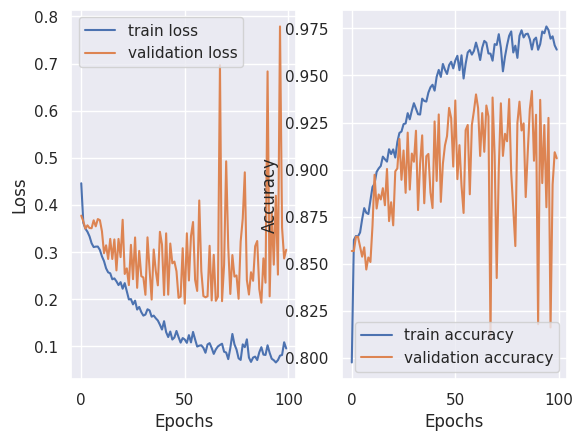

In [150]:
nir_net_freezed, _ = train_resnet_freezed(train_dataset_nir, val_dataset_nir, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.4425, Acc: 0.7972669536564624

Val Loss: 0.3801, Acc: 0.8567708333333334
Train Loss: 0.3565, Acc: 0.8637595663265308

Val Loss: 0.3559, Acc: 0.863530316787732
Train Loss: 0.3447, Acc: 0.8665032419217686

Val Loss: 0.3558, Acc: 0.8503833736884584
Train Loss: 0.3345, Acc: 0.8677721088435372

Val Loss: 0.3588, Acc: 0.8503518462469734
Train Loss: 0.3211, Acc: 0.8723294005102041

Val Loss: 0.3671, Acc: 0.844645379338176
Train Loss: 0.3157, Acc: 0.8768401892006801

Val Loss: 0.3925, Acc: 0.8703528551251009
Train Loss: 0.3162, Acc: 0.8732926764455781

Val Loss: 0.3258, Acc: 0.8711284301856336
Train Loss: 0.3029, Acc: 0.8806999362244898

Val Loss: 0.4129, Acc: 0.8420727401129943
Train Loss: 0.2969, Acc: 0.8836761267006801

Val Loss: 0.3305, Acc: 0.8696655569007264
Train Loss: 0.2910, Acc: 0.8853701636904762

Val Loss: 0.4118, Acc: 0.8555286521388217
Train Loss: 0.2913, Acc: 0.8876488095238096

Val Loss: 0.4234, Acc: 0.8494123284907183
Train Loss: 0.2821, Acc: 0.8906515731292516



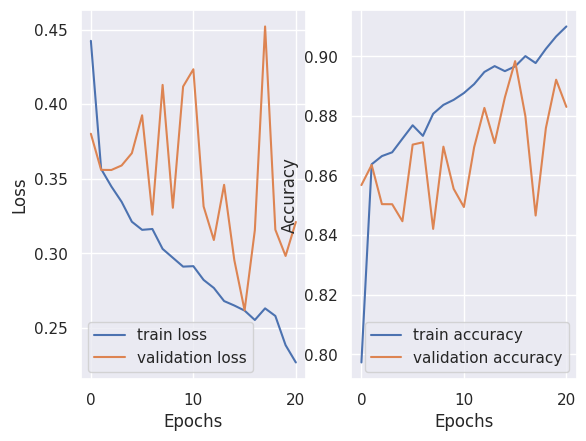

Train Loss: 0.2307, Acc: 0.9081034757653063

Val Loss: 0.3380, Acc: 0.8757251311541566
Train Loss: 0.2187, Acc: 0.9153911564625851

Val Loss: 0.3637, Acc: 0.8763304580306698
Train Loss: 0.2289, Acc: 0.9105083439625852

Val Loss: 0.2723, Acc: 0.8978384786117837
Train Loss: 0.2157, Acc: 0.915670174319728

Val Loss: 0.3496, Acc: 0.8880649717514125
Train Loss: 0.2142, Acc: 0.9155505952380952

Val Loss: 0.2771, Acc: 0.8903286420500404
Train Loss: 0.2086, Acc: 0.9161152742346941

Val Loss: 0.2615, Acc: 0.9014893563357548
Train Loss: 0.2028, Acc: 0.9202141794217688

Val Loss: 0.2896, Acc: 0.8949253430185634
Train Loss: 0.2020, Acc: 0.92117081207483

Val Loss: 0.2512, Acc: 0.8993581012913641
Train Loss: 0.2006, Acc: 0.9224131058673467

Val Loss: 0.2865, Acc: 0.895202784503632
Train Loss: 0.2025, Acc: 0.9218085671768704

Val Loss: 0.2458, Acc: 0.9077002623083131
Train Loss: 0.1889, Acc: 0.9254690157312928

Val Loss: 0.2567, Acc: 0.9020190173527037
Train Loss: 0.1837, Acc: 0.9282724808673467

Va

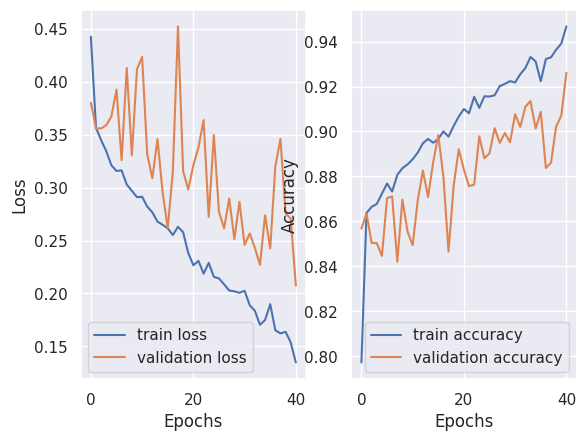

Train Loss: 0.1356, Acc: 0.9462159863945576

Val Loss: 0.2761, Acc: 0.8961927461662631
Train Loss: 0.1894, Acc: 0.9229047087585034

Val Loss: 0.2356, Acc: 0.910424233252623
Train Loss: 0.1649, Acc: 0.9340454931972791

Val Loss: 0.2191, Acc: 0.9149831012913641
Train Loss: 0.1538, Acc: 0.9407153486394558

Val Loss: 0.2636, Acc: 0.9054933414043583
Train Loss: 0.1450, Acc: 0.9428345556972788

Val Loss: 0.2291, Acc: 0.9151092110573043
Train Loss: 0.1492, Acc: 0.9422499468537415

Val Loss: 0.2140, Acc: 0.9222407183212268
Train Loss: 0.1434, Acc: 0.9454387223639454

Val Loss: 0.2202, Acc: 0.922833434221146
Train Loss: 0.1507, Acc: 0.9411405187074829

Val Loss: 0.2783, Acc: 0.9038854418886199
Train Loss: 0.1466, Acc: 0.9438509778911562

Val Loss: 0.3432, Acc: 0.8818288438256658
Train Loss: 0.1422, Acc: 0.9446880314625848

Val Loss: 0.2336, Acc: 0.9137472255851492
Train Loss: 0.1432, Acc: 0.9423030931122448

Val Loss: 0.2158, Acc: 0.9290065072639225
Train Loss: 0.1360, Acc: 0.9471194727891157



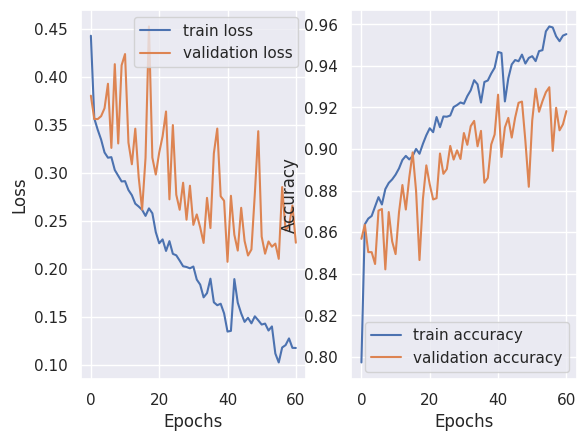

Train Loss: 0.1128, Acc: 0.9568319515306123

Val Loss: 0.2141, Acc: 0.9326699959644875
Train Loss: 0.0989, Acc: 0.9615686118197279

Val Loss: 0.2591, Acc: 0.914522800645682
Train Loss: 0.0986, Acc: 0.9629769876700679

Val Loss: 0.2641, Acc: 0.9133121468926554
Train Loss: 0.1022, Acc: 0.9635682397959183

Val Loss: 0.3239, Acc: 0.8895278450363197
Train Loss: 0.1165, Acc: 0.9567123724489797

Val Loss: 0.4163, Acc: 0.8657120157384988
Train Loss: 0.1311, Acc: 0.9495176977040813

Val Loss: 0.2530, Acc: 0.9130347054075868
Train Loss: 0.1034, Acc: 0.9611766581632654

Val Loss: 0.2263, Acc: 0.9203238498789347
Train Loss: 0.0979, Acc: 0.9641594919217685

Val Loss: 0.3635, Acc: 0.88093346448749
Train Loss: 0.0995, Acc: 0.9622329400510204

Val Loss: 0.2693, Acc: 0.917807960048426
Train Loss: 0.1041, Acc: 0.9619672087585033

Val Loss: 0.2674, Acc: 0.9165090294592413
Train Loss: 0.0905, Acc: 0.9649899022108843

Val Loss: 0.3183, Acc: 0.9103044289749799
Train Loss: 0.0741, Acc: 0.9715733949829932

Va

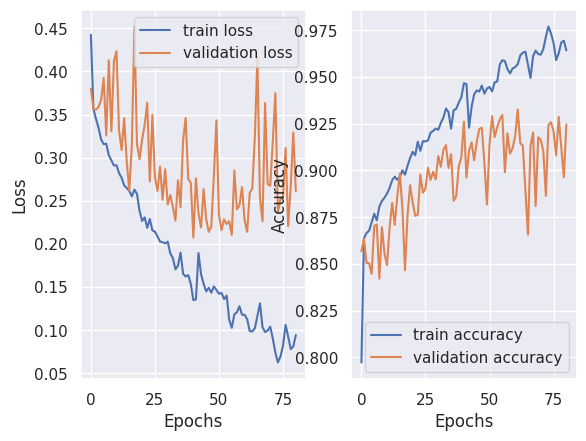

Train Loss: 0.0635, Acc: 0.9778180803571431

Val Loss: 0.2762, Acc: 0.9181799838579501
Train Loss: 0.0614, Acc: 0.9764030612244897

Val Loss: 0.2148, Acc: 0.9340635088781276
Train Loss: 0.0883, Acc: 0.9659996811224488

Val Loss: 0.3231, Acc: 0.9098062953995157
Train Loss: 0.0717, Acc: 0.9736859587585033

Val Loss: 0.2256, Acc: 0.9293470036319613
Train Loss: 0.0626, Acc: 0.9757188031462585

Val Loss: 0.2257, Acc: 0.9324493038740921
Train Loss: 0.0729, Acc: 0.9754132121598637

Val Loss: 0.2495, Acc: 0.9273040254237288
Train Loss: 0.0906, Acc: 0.9648238201530613

Val Loss: 0.3639, Acc: 0.8801578894269572
Train Loss: 0.1043, Acc: 0.9622528698979593

Val Loss: 0.5242, Acc: 0.8536937550443907
Train Loss: 0.0767, Acc: 0.9707695578231292

Val Loss: 0.2073, Acc: 0.934334644874899
Train Loss: 0.0692, Acc: 0.9748950361394558

Val Loss: 0.2332, Acc: 0.9326321630347055
Train Loss: 0.0534, Acc: 0.9807012648809524

Val Loss: 0.2505, Acc: 0.9245106941081517
Train Loss: 0.0477, Acc: 0.9814851721938775


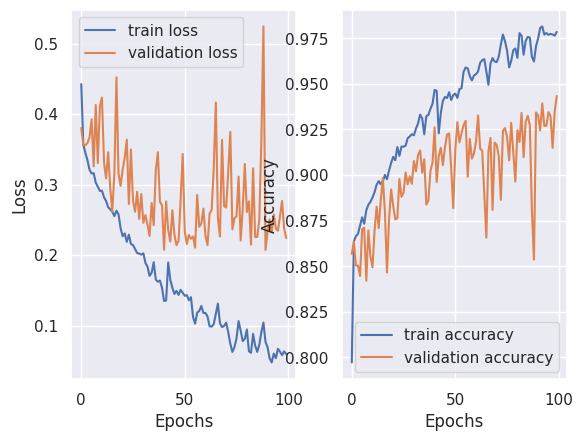

In [151]:
cycle_gan_net_freezed, _ = train_resnet_freezed(train_dataset_cycle_gan, val_dataset_cycle_gan, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.4476, Acc: 0.7979777848639457

Val Loss: 0.3747, Acc: 0.8567708333333334
Train Loss: 0.3595, Acc: 0.8628295068027209

Val Loss: 0.3697, Acc: 0.8549107142857143
Train Loss: 0.3469, Acc: 0.8645966198979592

Val Loss: 0.3984, Acc: 0.8523380750605328
Train Loss: 0.3385, Acc: 0.8672937925170068

Val Loss: 0.3716, Acc: 0.8445192695722357
Train Loss: 0.3287, Acc: 0.8683766475340137

Val Loss: 0.3774, Acc: 0.8388758575464085
Train Loss: 0.3210, Acc: 0.8743290284863945

Val Loss: 0.4060, Acc: 0.8515625
Train Loss: 0.3179, Acc: 0.8704559948979592

Val Loss: 0.4070, Acc: 0.8470288539144472
Train Loss: 0.3051, Acc: 0.8789461096938775

Val Loss: 0.3805, Acc: 0.853826170298628
Train Loss: 0.3007, Acc: 0.8836761267006804

Val Loss: 0.4138, Acc: 0.8458875605326877
Train Loss: 0.2938, Acc: 0.8834967580782315

Val Loss: 0.4382, Acc: 0.8387245258272801
Train Loss: 0.2910, Acc: 0.8851509353741497

Val Loss: 0.5390, Acc: 0.8406098668280872
Train Loss: 0.2857, Acc: 0.8885921556122449

Val Loss

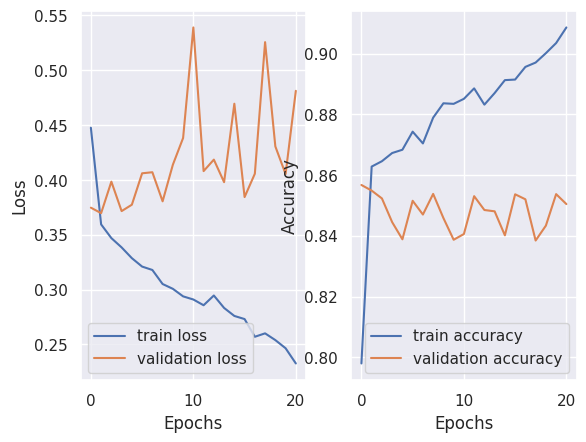

Train Loss: 0.2328, Acc: 0.9076052295918365

Val Loss: 0.4458, Acc: 0.8451750403551251
Train Loss: 0.2149, Acc: 0.9130062181122449

Val Loss: 0.4596, Acc: 0.851064366424536
Train Loss: 0.2195, Acc: 0.9135576105442175

Val Loss: 0.4904, Acc: 0.8417007163034705
Train Loss: 0.2170, Acc: 0.9147534013605441

Val Loss: 0.4200, Acc: 0.8456668684422922
Train Loss: 0.2119, Acc: 0.9130593643707483

Val Loss: 0.4448, Acc: 0.846530720338983
Train Loss: 0.2099, Acc: 0.9141488626700679

Val Loss: 0.4448, Acc: 0.8503203188054883
Train Loss: 0.1945, Acc: 0.9211442389455783

Val Loss: 0.4467, Acc: 0.8582274011299434
Train Loss: 0.1869, Acc: 0.9242466517857145

Val Loss: 0.4950, Acc: 0.8392541868442293
Train Loss: 0.1913, Acc: 0.9234494579081631

Val Loss: 0.4977, Acc: 0.8404900625504439
Train Loss: 0.1884, Acc: 0.9274819302721089

Val Loss: 0.4798, Acc: 0.8483340899919289
Train Loss: 0.1917, Acc: 0.925163424744898

Val Loss: 0.4912, Acc: 0.852457879338176
Train Loss: 0.1900, Acc: 0.9232634460034014

Va

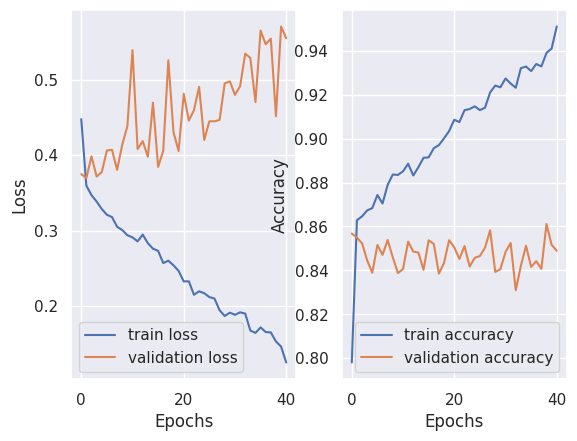

Train Loss: 0.1216, Acc: 0.9496306335034016

Val Loss: 0.5105, Acc: 0.8546269673123487
Train Loss: 0.1410, Acc: 0.9436649659863945

Val Loss: 0.4861, Acc: 0.8643689467312349
Train Loss: 0.1247, Acc: 0.9513180272108847

Val Loss: 0.5291, Acc: 0.8523696025020177
Train Loss: 0.1310, Acc: 0.9476775085034012

Val Loss: 0.5394, Acc: 0.8575148809523809
Train Loss: 0.1299, Acc: 0.950288318452381

Val Loss: 0.4920, Acc: 0.8561213680387411
Train Loss: 0.1232, Acc: 0.946734162414966

Val Loss: 0.5012, Acc: 0.8526785714285715
Train Loss: 0.1206, Acc: 0.9541414221938775

Val Loss: 0.5020, Acc: 0.8545639124293786
Train Loss: 0.1249, Acc: 0.9506404124149658

Val Loss: 0.6076, Acc: 0.8420096852300242
Train Loss: 0.1299, Acc: 0.9463953550170068

Val Loss: 0.5933, Acc: 0.8495132163034705
Train Loss: 0.1329, Acc: 0.944953762755102

Val Loss: 0.5515, Acc: 0.8489268058918483
Train Loss: 0.1323, Acc: 0.9489330888605442

Val Loss: 0.5506, Acc: 0.8553773204196933
Train Loss: 0.1324, Acc: 0.948953018707483

Va

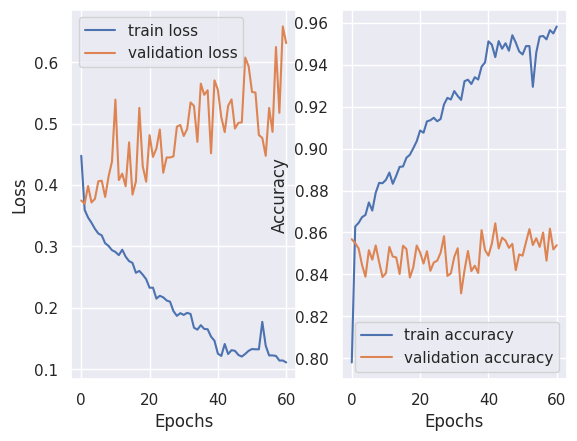

Train Loss: 0.0960, Acc: 0.9644650829081632

Val Loss: 0.5838, Acc: 0.8566762510088782
Train Loss: 0.0886, Acc: 0.9649433992346937

Val Loss: 0.5771, Acc: 0.8455155367231639
Train Loss: 0.0923, Acc: 0.9667636585884355

Val Loss: 0.5930, Acc: 0.8489520278450363
Train Loss: 0.1170, Acc: 0.9572836947278912

Val Loss: 0.6548, Acc: 0.8381318099273608
Train Loss: 0.1172, Acc: 0.9546130952380953

Val Loss: 0.5394, Acc: 0.856619501614205
Train Loss: 0.1040, Acc: 0.9594560480442177

Val Loss: 0.5630, Acc: 0.8497969632768362
Train Loss: 0.0780, Acc: 0.9705104698129251

Val Loss: 0.5387, Acc: 0.8573004943502825
Train Loss: 0.0824, Acc: 0.9699723639455783

Val Loss: 0.6059, Acc: 0.8499798224374496
Train Loss: 0.1046, Acc: 0.961030505952381

Val Loss: 0.5990, Acc: 0.8483403954802261
Train Loss: 0.0944, Acc: 0.9643986500850339

Val Loss: 0.5612, Acc: 0.8527731537530266
Train Loss: 0.0817, Acc: 0.9705436862244898

Val Loss: 0.5636, Acc: 0.8578238498789347
Train Loss: 0.0731, Acc: 0.9705503295068026



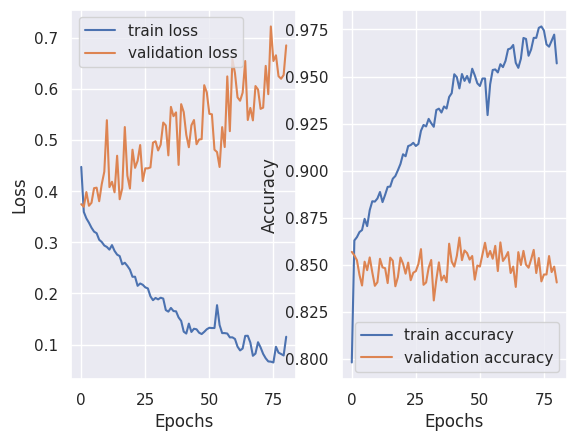

Train Loss: 0.0804, Acc: 0.9695139774659863

Val Loss: 0.6144, Acc: 0.847407183212268
Train Loss: 0.0591, Acc: 0.9778247236394558

Val Loss: 0.6706, Acc: 0.852861430589185
Train Loss: 0.0660, Acc: 0.9768481611394556

Val Loss: 0.6297, Acc: 0.8510013115415657
Train Loss: 0.0646, Acc: 0.977519132653061

Val Loss: 0.6845, Acc: 0.8452380952380952
Train Loss: 0.0647, Acc: 0.9753534226190474

Val Loss: 0.7903, Acc: 0.8418520480225989
Train Loss: 0.0835, Acc: 0.9699723639455784

Val Loss: 0.6248, Acc: 0.8490844430992737
Train Loss: 0.0849, Acc: 0.9709422831632654

Val Loss: 0.5881, Acc: 0.8348151230831315
Train Loss: 0.0875, Acc: 0.9714471726190474

Val Loss: 0.5974, Acc: 0.8570167473769169
Train Loss: 0.0487, Acc: 0.9830729166666669

Val Loss: 0.5985, Acc: 0.8560267857142857
Train Loss: 0.0377, Acc: 0.9872448979591838

Val Loss: 0.6416, Acc: 0.8565564467312349
Train Loss: 0.0337, Acc: 0.9888392857142856

Val Loss: 0.6108, Acc: 0.8549422417271995
Train Loss: 0.0347, Acc: 0.9889987244897956

V

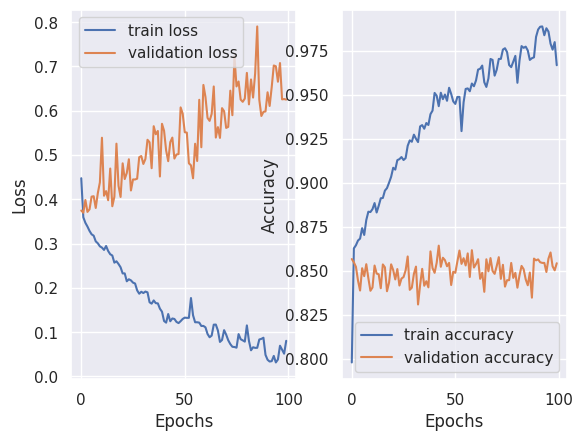

In [152]:
iis_net_freezed, _ = train_resnet_freezed(train_dataset_iis, val_dataset_iis, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.4485, Acc: 0.7954666241496601

Val Loss: 0.3741, Acc: 0.8567708333333334
Train Loss: 0.3644, Acc: 0.859594228316327

Val Loss: 0.3644, Acc: 0.8563988095238094
Train Loss: 0.3538, Acc: 0.8617599383503403

Val Loss: 0.3589, Acc: 0.861701725181598
Train Loss: 0.3484, Acc: 0.8625837053571428

Val Loss: 0.3561, Acc: 0.862571882566586
Train Loss: 0.3465, Acc: 0.8651546556122449

Val Loss: 0.3512, Acc: 0.8628808514931396
Train Loss: 0.3422, Acc: 0.8672007865646258

Val Loss: 0.3599, Acc: 0.8627862691686844
Train Loss: 0.3393, Acc: 0.8678186118197279

Val Loss: 0.3525, Acc: 0.8617332526230831
Train Loss: 0.3346, Acc: 0.8692004145408164

Val Loss: 0.3678, Acc: 0.8594695823244551
Train Loss: 0.3379, Acc: 0.8660847151360543

Val Loss: 0.3615, Acc: 0.8651129943502825
Train Loss: 0.3273, Acc: 0.8679315476190476

Val Loss: 0.3490, Acc: 0.8675910512510088
Train Loss: 0.3291, Acc: 0.8694329294217686

Val Loss: 0.3473, Acc: 0.8624142453591607
Train Loss: 0.3210, Acc: 0.8716982886904763

V

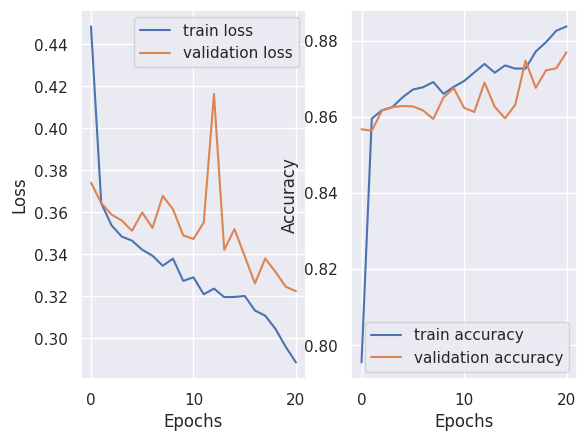

Train Loss: 0.2817, Acc: 0.8880739795918365

Val Loss: 0.3292, Acc: 0.8721499192897498
Train Loss: 0.2774, Acc: 0.8897680165816326

Val Loss: 0.3344, Acc: 0.8592804176755449
Train Loss: 0.2785, Acc: 0.8893029868197279

Val Loss: 0.3256, Acc: 0.8748801957223568
Train Loss: 0.2718, Acc: 0.8934550382653065

Val Loss: 0.3242, Acc: 0.867654106133979
Train Loss: 0.2720, Acc: 0.8910767431972793

Val Loss: 0.3270, Acc: 0.8726795803066989
Train Loss: 0.2676, Acc: 0.8952022215136055

Val Loss: 0.3113, Acc: 0.8760908494753834
Train Loss: 0.2657, Acc: 0.8931893069727891

Val Loss: 0.3247, Acc: 0.8749747780468119
Train Loss: 0.2598, Acc: 0.898510576105442

Val Loss: 0.3206, Acc: 0.8696403349475382
Train Loss: 0.2594, Acc: 0.8962717899659864

Val Loss: 0.3160, Acc: 0.8744766444713479
Train Loss: 0.2708, Acc: 0.8926711309523809

Val Loss: 0.3220, Acc: 0.8782599374495561
Train Loss: 0.2592, Acc: 0.8986367984693877

Val Loss: 0.3155, Acc: 0.8797165052461663
Train Loss: 0.2585, Acc: 0.8964976615646257



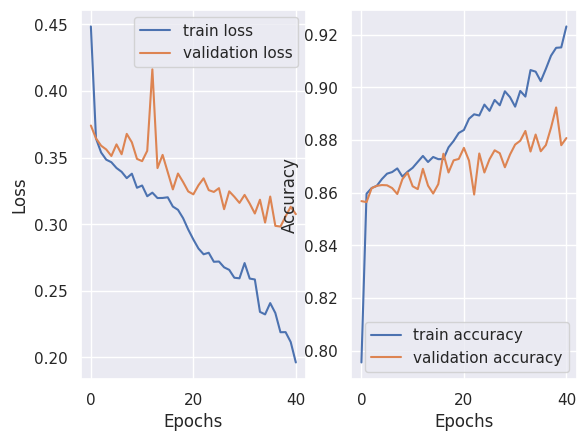

Train Loss: 0.1933, Acc: 0.92117081207483

Val Loss: 0.3098, Acc: 0.8834682707828895
Train Loss: 0.1970, Acc: 0.921948076105442

Val Loss: 0.3270, Acc: 0.8779509685230025
Train Loss: 0.1838, Acc: 0.9269969706632653

Val Loss: 0.3159, Acc: 0.8896728712671509
Train Loss: 0.1819, Acc: 0.927202912414966

Val Loss: 0.3253, Acc: 0.8824152542372882
Train Loss: 0.1830, Acc: 0.9300395939625851

Val Loss: 0.3042, Acc: 0.8842753732849071
Train Loss: 0.1889, Acc: 0.923024287840136

Val Loss: 0.3064, Acc: 0.8862363801452785
Train Loss: 0.2008, Acc: 0.9199085884353742

Val Loss: 0.3310, Acc: 0.8673136097659403
Train Loss: 0.2134, Acc: 0.9135177508503403

Val Loss: 0.3389, Acc: 0.8626034100080711
Train Loss: 0.1984, Acc: 0.9220145089285715

Val Loss: 0.3015, Acc: 0.8825098365617433
Train Loss: 0.1851, Acc: 0.927714445153061

Val Loss: 0.3308, Acc: 0.8865390435835351
Train Loss: 0.1861, Acc: 0.9259340454931974

Val Loss: 0.3161, Acc: 0.8826674737691688
Train Loss: 0.1919, Acc: 0.9234627444727891

Val 

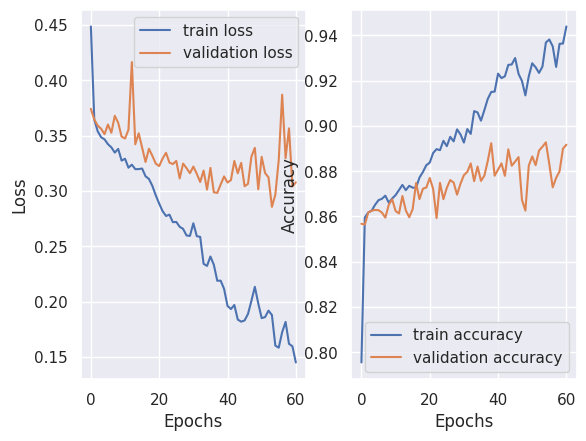

Train Loss: 0.1487, Acc: 0.9407684948979593

Val Loss: 0.3215, Acc: 0.8884054681194512
Train Loss: 0.1297, Acc: 0.9481890412414966

Val Loss: 0.3256, Acc: 0.8893323748991122
Train Loss: 0.1417, Acc: 0.9469068877551021

Val Loss: 0.3415, Acc: 0.8837772397094431
Train Loss: 0.1405, Acc: 0.9465813669217686

Val Loss: 0.3776, Acc: 0.8714689265536723
Train Loss: 0.1309, Acc: 0.9513645301870749

Val Loss: 0.3358, Acc: 0.8870434826472962
Train Loss: 0.1125, Acc: 0.9583997661564626

Val Loss: 0.3416, Acc: 0.8811730730427764
Train Loss: 0.0989, Acc: 0.9633689413265305

Val Loss: 0.3336, Acc: 0.8908835250201775
Train Loss: 0.1297, Acc: 0.9512515943877551

Val Loss: 0.3699, Acc: 0.8803974979822438
Train Loss: 0.1306, Acc: 0.9482820471938777

Val Loss: 0.3554, Acc: 0.8872200363196127
Train Loss: 0.1070, Acc: 0.960572119472789

Val Loss: 0.3437, Acc: 0.8895845944309927
Train Loss: 0.1082, Acc: 0.9588515093537416

Val Loss: 0.3409, Acc: 0.8939227703793381
Train Loss: 0.1218, Acc: 0.952301232993197



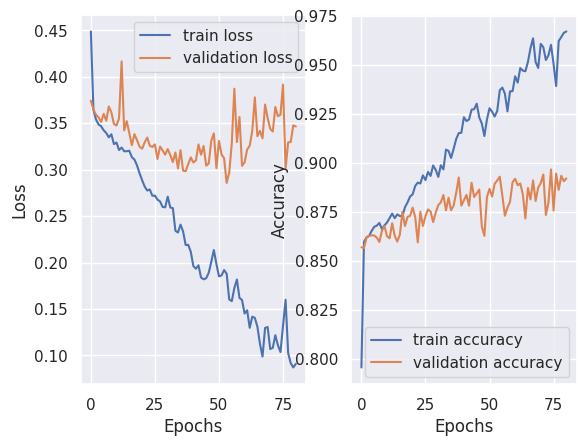

Train Loss: 0.0852, Acc: 0.9690755208333334

Val Loss: 0.3459, Acc: 0.8925544794188861
Train Loss: 0.0700, Acc: 0.9741974914965986

Val Loss: 0.3909, Acc: 0.8855175544794189
Train Loss: 0.0800, Acc: 0.9681919642857143

Val Loss: 0.3741, Acc: 0.8947929277643261
Train Loss: 0.0959, Acc: 0.9626182504251696

Val Loss: 0.3845, Acc: 0.8914447134786118
Train Loss: 0.0702, Acc: 0.9723373724489796

Val Loss: 0.3450, Acc: 0.8936453288942695
Train Loss: 0.0752, Acc: 0.9741443452380949

Val Loss: 0.3554, Acc: 0.894729872881356
Train Loss: 0.0811, Acc: 0.9699524340986397

Val Loss: 0.3748, Acc: 0.8912618543179983
Train Loss: 0.0901, Acc: 0.9684842687074829

Val Loss: 0.3814, Acc: 0.8847482849071833
Train Loss: 0.0837, Acc: 0.9679926658163266

Val Loss: 0.3623, Acc: 0.8862300746569814
Train Loss: 0.0604, Acc: 0.9769411670918369

Val Loss: 0.3647, Acc: 0.8974286218724777
Train Loss: 0.0551, Acc: 0.9794789009353743

Val Loss: 0.3794, Acc: 0.8944209039548022
Train Loss: 0.0563, Acc: 0.980103369472789



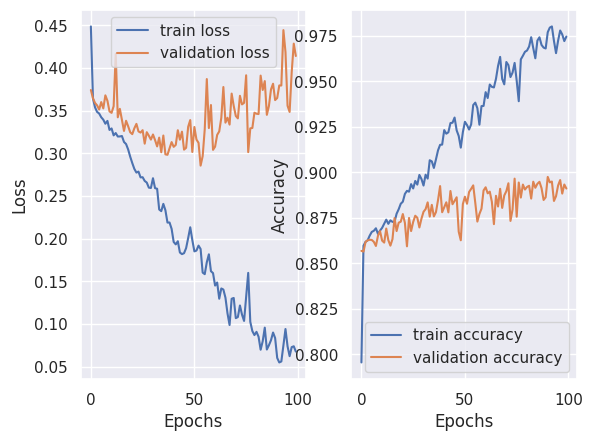

In [153]:
ihfs_net_freezed, _ = train_resnet_freezed(train_dataset_ihfs, val_dataset_ihfs, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.4425, Acc: 0.7974529655612246

Val Loss: 0.3762, Acc: 0.8567708333333334
Train Loss: 0.3542, Acc: 0.8649221407312927

Val Loss: 0.3630, Acc: 0.8612351190476191
Train Loss: 0.3453, Acc: 0.8664102359693878

Val Loss: 0.3491, Acc: 0.8649553571428572
Train Loss: 0.3356, Acc: 0.8690741921768708

Val Loss: 0.3503, Acc: 0.8628493240516546
Train Loss: 0.3259, Acc: 0.8732926764455783

Val Loss: 0.3467, Acc: 0.8651760492332526
Train Loss: 0.3204, Acc: 0.8756975446428573

Val Loss: 0.3421, Acc: 0.8730200766747377
Train Loss: 0.3148, Acc: 0.8754318133503401

Val Loss: 0.3426, Acc: 0.8646463882163035
Train Loss: 0.3064, Acc: 0.8772454294217688

Val Loss: 0.3323, Acc: 0.8672820823244551
Train Loss: 0.3032, Acc: 0.8830715880102041

Val Loss: 0.3390, Acc: 0.8688332324455206
Train Loss: 0.2970, Acc: 0.8803345556972789

Val Loss: 0.3300, Acc: 0.8673766646489104
Train Loss: 0.2944, Acc: 0.8845596832482995

Val Loss: 0.4002, Acc: 0.8594317493946732
Train Loss: 0.2834, Acc: 0.8881669855442175

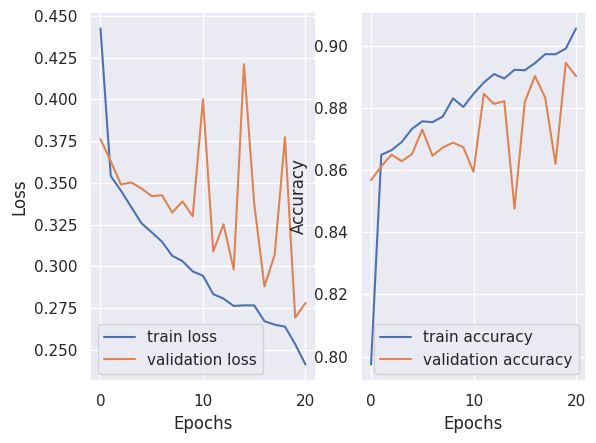

Train Loss: 0.2369, Acc: 0.9063695790816325

Val Loss: 0.2920, Acc: 0.8837835451977402
Train Loss: 0.2266, Acc: 0.9102758290816326

Val Loss: 0.3432, Acc: 0.8664497578692494
Train Loss: 0.2247, Acc: 0.9089272427721086

Val Loss: 0.2579, Acc: 0.9042826876513317
Train Loss: 0.2193, Acc: 0.9103090454931974

Val Loss: 0.2593, Acc: 0.8964386602098466
Train Loss: 0.2225, Acc: 0.9108205782312927

Val Loss: 0.2513, Acc: 0.9000958434221147
Train Loss: 0.2105, Acc: 0.9160687712585035

Val Loss: 0.2500, Acc: 0.9037593321226796
Train Loss: 0.2107, Acc: 0.9181680484693878

Val Loss: 0.4318, Acc: 0.8638455912025828
Train Loss: 0.2111, Acc: 0.9161949936224492

Val Loss: 0.3762, Acc: 0.8521236884584343
Train Loss: 0.2107, Acc: 0.9164275085034016

Val Loss: 0.2530, Acc: 0.903046811945117
Train Loss: 0.2070, Acc: 0.9200148809523808

Val Loss: 0.2706, Acc: 0.8951082021791769
Train Loss: 0.2106, Acc: 0.9180285395408164

Val Loss: 0.2982, Acc: 0.884622175141243
Train Loss: 0.1961, Acc: 0.9215295493197279



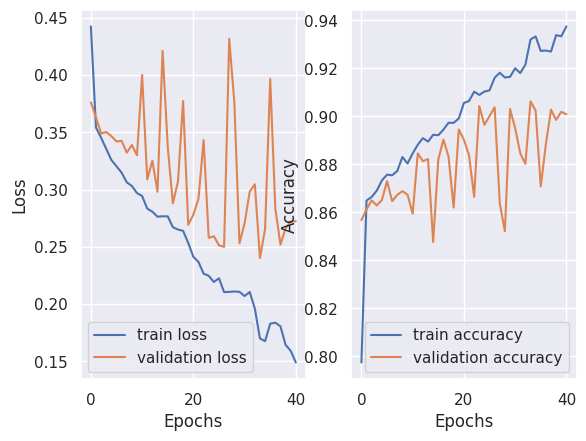

Train Loss: 0.1603, Acc: 0.9359654017857141

Val Loss: 0.2656, Acc: 0.8934624697336561
Train Loss: 0.1545, Acc: 0.9350419855442178

Val Loss: 0.3812, Acc: 0.8620106941081517
Train Loss: 0.1492, Acc: 0.9409545068027211

Val Loss: 0.3049, Acc: 0.8910096347861178
Train Loss: 0.1537, Acc: 0.9420373618197279

Val Loss: 0.2443, Acc: 0.9095919087974172
Train Loss: 0.1432, Acc: 0.9452394238945577

Val Loss: 0.2898, Acc: 0.8839096549636803
Train Loss: 0.1474, Acc: 0.9415391156462581

Val Loss: 0.6695, Acc: 0.7927449051654559
Train Loss: 0.1406, Acc: 0.9466743728741497

Val Loss: 0.2743, Acc: 0.9054050645682001
Train Loss: 0.1616, Acc: 0.9375265731292514

Val Loss: 0.4701, Acc: 0.8568969430992737
Train Loss: 0.1432, Acc: 0.9420705782312925

Val Loss: 0.3621, Acc: 0.8751954701372074
Train Loss: 0.1260, Acc: 0.9499229379251699

Val Loss: 0.4134, Acc: 0.8631330710250201
Train Loss: 0.1352, Acc: 0.946627869897959

Val Loss: 0.2814, Acc: 0.901218220338983
Train Loss: 0.1320, Acc: 0.9506869153911565



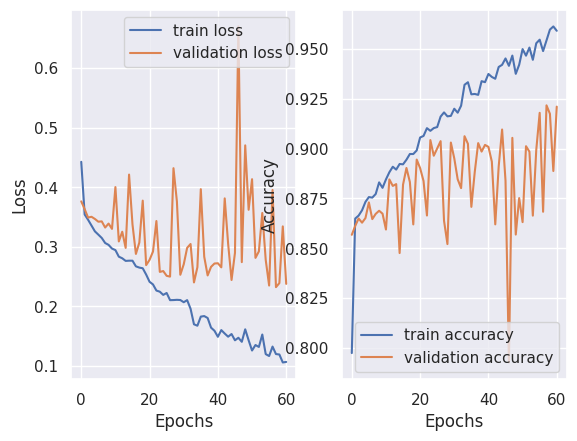

Train Loss: 0.1102, Acc: 0.9560281143707482

Val Loss: 0.4424, Acc: 0.8749117231638418
Train Loss: 0.0986, Acc: 0.9633955144557822

Val Loss: 0.3349, Acc: 0.8833232445520581
Train Loss: 0.0890, Acc: 0.9667304421768707

Val Loss: 0.2285, Acc: 0.9235144269572236
Train Loss: 0.1090, Acc: 0.9618808460884355

Val Loss: 0.2553, Acc: 0.9171269673123487
Train Loss: 0.1191, Acc: 0.9564732142857141

Val Loss: 0.3042, Acc: 0.9010353611783697
Train Loss: 0.1098, Acc: 0.9578417304421768

Val Loss: 0.2493, Acc: 0.9158532586763518
Train Loss: 0.0851, Acc: 0.9677468643707484

Val Loss: 0.2220, Acc: 0.9229910714285715
Train Loss: 0.0895, Acc: 0.9677734374999999

Val Loss: 0.4292, Acc: 0.8741739810330912
Train Loss: 0.1086, Acc: 0.9584994153911564

Val Loss: 0.2664, Acc: 0.910897144874899
Train Loss: 0.1228, Acc: 0.9515372555272107

Val Loss: 0.2918, Acc: 0.8970944309927361
Train Loss: 0.1086, Acc: 0.9594029017857143

Val Loss: 0.2741, Acc: 0.909005498385795
Train Loss: 0.0988, Acc: 0.9618742028061223



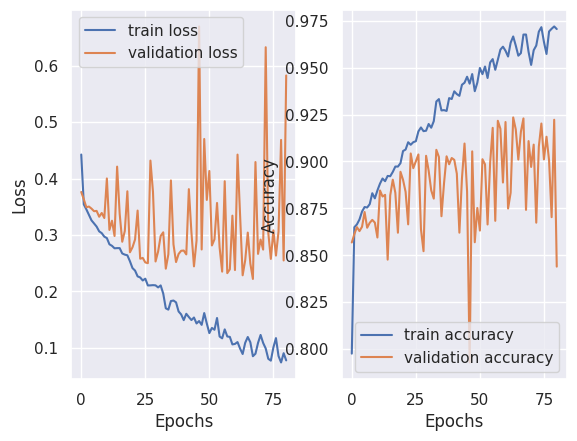

Train Loss: 0.0600, Acc: 0.9772002551020407

Val Loss: 0.2614, Acc: 0.9147119652945924
Train Loss: 0.0533, Acc: 0.9811596513605442

Val Loss: 0.2255, Acc: 0.9311503732849071
Train Loss: 0.0822, Acc: 0.9679195897108843

Val Loss: 0.2453, Acc: 0.9184258979015335
Train Loss: 0.0782, Acc: 0.9722642963435373

Val Loss: 0.2522, Acc: 0.923672064164649
Train Loss: 0.0743, Acc: 0.9716597576530613

Val Loss: 0.2239, Acc: 0.9248196630347055
Train Loss: 0.0613, Acc: 0.9766023596938777

Val Loss: 0.2685, Acc: 0.9115466101694915
Train Loss: 0.0709, Acc: 0.9724503082482995

Val Loss: 0.2884, Acc: 0.9068048829701372
Train Loss: 0.1082, Acc: 0.9603595344387755

Val Loss: 0.2916, Acc: 0.9157902037933817
Train Loss: 0.0634, Acc: 0.975771949404762

Val Loss: 0.2480, Acc: 0.9173665758676351
Train Loss: 0.0587, Acc: 0.981518388605442

Val Loss: 0.2307, Acc: 0.9239810330912025
Train Loss: 0.0641, Acc: 0.9768880208333335

Val Loss: 0.2468, Acc: 0.9211561743341404
Train Loss: 0.0379, Acc: 0.9866735756802725

V

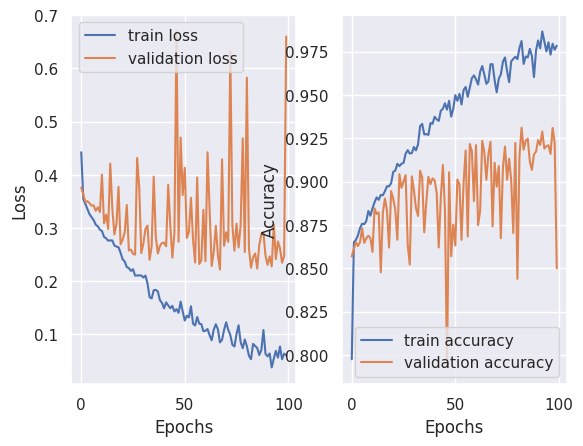

In [154]:
iis_cycle_gan_net_freezed, _ = train_resnet_freezed(train_dataset_iis_cycle_gan, val_dataset_iis_cycle_gan, 1e-4)

In [155]:
def test(model, test_loader, show_images=20):
    model.eval()

    running_acc = 0
    total = 0
    showed = 1
    with torch.no_grad():
        for counter, data in enumerate(test_loader):
            image, target = data['image'].to(device), data['labels']
            outputs = model(image).detach().cpu()
            prob = torch.sigmoid(outputs)

            acc = accuracy(prob, target)

            pred = torch.argmax(prob)
            pred_as_string = str(pred.item())

            running_acc += acc

            if showed < show_images and len(pred.flatten()) > 0:
                image = image.squeeze(0)
                image = image.detach().cpu().numpy()
                image = np.transpose(image, (1, 2, 0))
                plt.imshow(image)
                plt.axis('off')

                indices = np.argwhere(target.flatten())
                indices_as_string = " ".join([str(label.item()) for label in indices.flatten()])

                plt.title(f"PREDICTED: {pred_as_string}\nACTUAL: {indices_as_string}")
                plt.show()

                showed += 1

            total += 1

    return running_acc / total

In [156]:
test_dataset_rgb = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_rgb_test
)
test_dataset_nir = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_nir_test
)
test_dataset_iis = SerengetiDataset(
    transform=validation_transformations,
    result=iis_serengeti_night_large_test
)
test_dataset_cycle_gan = SerengetiDataset(
    transform=validation_transformations,
    result=cycle_gan_serengeti_night_large_test,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)
test_dataset_ihfs = SerengetiDataset(
    transform=validation_transformations,
    result=ihfs_serengeti_night_large_test,
)
test_dataset_iis_cycle_gan = SerengetiDataset(
    transform=validation_transformations,
    result=iis_cycle_gan_serengeti_night_large_test,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)

In [157]:
print("NIR", test(nir_net_freezed, DataLoader(test_dataset_nir, batch_size=1, shuffle=False), show_images=0))
print("CycleGAN",
      test(cycle_gan_net_freezed, DataLoader(test_dataset_cycle_gan, batch_size=1, shuffle=False), show_images=0))
print("IIS",
      test(iis_net_freezed, DataLoader(test_dataset_iis, batch_size=1, shuffle=False), show_images=0))
print("IHFS",
      test(ihfs_net_freezed, DataLoader(test_dataset_ihfs, batch_size=1, shuffle=False), show_images=0))
print("IIS CycleGAN",
      test(iis_cycle_gan_net_freezed, DataLoader(test_dataset_iis_cycle_gan, batch_size=1, shuffle=False), show_images=0))

NIR 0.9376479873717445
CycleGAN 0.9360694554064724
IIS 0.8634569850039441
IHFS 0.8962115232833461
IIS CycleGAN 0.9392265193370167
